# Task05 DeepWalk论文精读

## 1 DeepWalk简介

### 1.1 相关概念

- DeepWalk主要将Graph的每一个节点编码成一个D维向量，Embedding中隐式包含了Graph中的社群、连接、结构信息，可用于后续节点分类等下游任务

- Embedding：例如Word2Vec，将单词转化为词向量，保留单词的语义关系
- 图嵌入：将节点空间编码成向量空间
- 图嵌入的应用：MNIST手写数字数据集的神经网络编码后降维可视化、建筑图像数据集VGG编码后降维可视化

### 1.2 Word2Vec词向量、词嵌入

假设：相邻单词应该具有相似的Embedding。

- CBOW（连续词袋任务）：输入周围词预测中心词
- Skip-Gram：输入中心词预测周围词

使用上述两个方法，构造自监督的任务，可以编码成词向量

### 1.3 随机游走Ramdom Walk

- 假设：相邻节点应该具有相似的Embedding
- 随机游走：有一个醉汉在节点中游走，形成随机游走序列

### 1.4 官方PPT讲解

- 机器学习的第一步需要提取图特征，得到节点、连接，转换为邻接矩阵，可以进行降维操作
- 优点：
    - 不需要重新训练，只需要输入新节点和新连接关系，再进行增量训练
    - 可以套用NLP
    - 训练效果很好

- 语言模型：使用Word2Vec将词变成词向量
- Short random walks = sentences

- Deepwalk步骤：
    1. 输入图
    2. 随机游走，采样随机游走序列
    3. 用随机游走序列训练成Word2Vec
    4. 使用Softmax（霍夫曼编码数）
    5. 得到节点的图嵌入向量表示

**Deepwalk具体步骤：**

1. Random Walks：生成 $\gamma$ 条随机游走序列，每个随机游走序列长度为$t$
2. Representation Mapping：构造Skip-gram任务，输入中心词预测周围词$Pr(v_j|\Phi(v_i))$
3. Hierarchical Softmax：使用霍夫曼树，输入节点的嵌入表示，进行逻辑二分类
4. Learning：需要两个参数，每一个节点的嵌入表、二分类的权重

- 改进措施：
    - Steaming：不需要知道全图数据
    - Non-Random Walks：可以采用不同措施，可以不采用随机

### 1.5 DeepWalk总结

- 首个将深度学习和自然语言处理的思想用于图机器学习
- 在稀疏标注节点分类场景下，嵌入性能卓越
- 均匀随机游走，没有偏向的游走方向
- 需要大量随机游走序列训练
- 基于随机游走，管中窥豹，距离较远的两个节点无法相互影响。看不到全图信息。
- 无监督，仅编码图的连接信息，没有利用节点的属性特征。
- 没有真正用到神经网络和深度学习

## 2 论文精读

论文题目：《DeepWalk：Online Learning of Social Representations》（DeepWalk：用于图节点嵌入的在线机器学习算法）

### 2.1 摘要

- DeepWalk用于学习隐式表征的表示学习方法，将节点在图中的连接关系进行编码，形成稠密低维连续的向量空间，可用于统计机器学习
- 在多类别网络分类任务上表现不错，例如BlogCatalog、Flickr和YouTube
- DeepWalk基于随机游走的，适用于稀疏标注的场景

### 2.2 介绍

- 背景：传统机器学习在稀疏性的数据上很难进行处理
- DeepWalk能够通过随机游走序列（邻域信息和社群信息），学习网络的连接结构信息，将节点转换为向量
- DeepWalk能用在标注数据稀疏的场景中，可以结合线性分类器，具备并行加速能力
- 贡献：
    1. DeepWalk能够通过随机游走序列，学习节点在网络中的关联和规律
    2. 在多个节点分类数据集上，DeepWalk在标注数据稀疏场景下能提高5%\~10%
    3. 可扩展性非常好，可以适用在YouTube数据集上

### 2.3 问题定义

- 假设：图$G=(V,E)$，其中$E \subseteq (V \times V) $，$G_L=(V, E, X, Y)$表示带标注的社交网络，$Y$表示标签
- 用随机游走序列采样连接信息，防止迭代产生的误差累计问题
- 目标：通过反映连接信息的Embedding和反映节点本身的特征，进行学习$X_E \in R^{|V| \times d}$数据集，结合简单的机器学习算法，解决分类问题。

### 2.4 学习表示

- 特性：
    1. 灵活可变、弹性扩容（Adaptability）
    2. 反映社群聚类信息（Community aware）：原图中相近的节点嵌入后依然相近
    3. 低维度（Low dimensional）：低纬度嵌入可以防止过拟合
    4. 连续（Continuous）：细微变化会产生影响

- 随机游走：从$v_i$点开始，通过随机过程，得到随机游走序列$W_{v_i}^1, W_{v_i}^2, \dots, W_{v_i}^k$；可以使用并行方式，在线增量进行随机游走。

- 幂律分布：在一个无标度网络中，中枢节点的连接数远高于其他节点，会产生长尾现象，也称为Zipf定律（词频排序名次与词频成正比，只有极少数的词被经常使用）

- 语言模型：用前i-1个词预测下文的第i个词，通过$Pr(v_i|(v_1, v_2, \cdots, v_{i-1}))$，使用提取Embedding的函数$\Phi:v \in V \mapsto R^{|V| \times d}$，可表示用前$i-1$个节点的Embedding预测第$i$个节点
$$
\text{Pr} \left ( v_i | (\Phi(v_1), \Phi(v_2), \cdots, \Phi(v_{i-1})) \right )
$$
- 用周围上下文预测中心词（CBOW），用中心词预测周围词（Skip-Gram），可构建自监督学习场景

- DeepWalk（Skip-Gram）损失函数：
$$
\min \limits_{\Phi} \ -\log \text{Pr}\left( \frac{\{ v_{i-w}, \cdots, v_{i+w} \}}{v_i} \big| \ \Phi(v_i) \right)
$$
其中
$$
\text{Pr}\left( \frac{\{ v_{i-w}, \cdots, v_{i+w} \}}{v_i} \big| \ \Phi(v_i) \right) = \prod_{j=i-w, j \neq i} \text{Pr}(v_j | \Phi(v_i))
$$

- DeepWalk能够把节点编码成低维、稠密、连续的向量，包含节点的结构、连接、社群特征，虽然不包含类别信息，但可用于预测类别信息

### 2.5 算法

1. DeepWalk算法：$\text{DeepWalk}(G, w, d, \gamma, t)$

> **Input：** graph $G(V,E)$  
&emsp;&emsp;window size $w$（左右窗口宽度）  
&emsp;&emsp;embedding size $d$（Embedding维度）  
&emsp;&emsp;walks per vertex $\gamma$（每个节点作为起始节点生成随机游走的次数）  
&emsp;&emsp;walk length $t$（随机游走最大长度）  
**Output：** maxtrix of vertex representations $\Phi \in R^{|V| \times d}$  
1: Initialization: Sample $\Phi$ from $\mathcal{U}^{|V| \times d}$  
2: Build a binary Tree $T$ from $V$  
3: for $i=0$ to $\gamma$ do  
4: &emsp;$\mathcal{O} = \text{Shuffle}(V)$ （随机打乱节点顺序）  
5: &emsp;for each $v_i \in \mathcal{O}$ do （遍历graph中的每个点）  
6: &emsp;&emsp;$\mathcal{W}_{v_i} = \text{RandomWalk}(G, v_i, t)$ （生成一个随机游走序列）   
7: &emsp;&emsp;$\text{SkipGram}(\Phi, \mathcal{W}_{v_i}, w)$ （由中心节点Embedding预测周围节点，更新Embedding）   
8: &emsp;end for  
9: end for

2. SkipGram算法：$\text{SkipGram}(\Phi, \mathcal{W}_{v_i}, w)$

> 1: for each $v_i \in \mathcal{W}_{v_i}$ do（遍历当前随机游走序列的每个字节）  
2: &emsp;for each $u_k \in \mathcal{W}_{v_i}[j-w, j+w]$ do（遍历该节点周围窗口里的每个点）   
3: &emsp;&emsp;$J(\Phi)=-\log \text{Pr}(u_k | \Phi(v_j))$（计算损失函数）    
4: &emsp;&emsp;$\displaystyle \Phi = \Phi - \alpha * \frac{\partial J}{\partial \Phi}$（梯度下降更新Embedding矩阵）  
5: &emsp;end for  
6: end for

3. 分层Sofmax（Hierachical Softmax）

计算公式：
$$
\text{Pr} (b_l \ | \ \Phi(v_j)) = 1 / (1 + e^{-\Phi(v_j) \cdot \Psi(b_l)})
$$

4. 多线程异步并行：加速训练，性能不变

- 变种：
    - Streaming：在未知全图时，直接用采样出的随机游走训练Embedding
    - Non-random walk：不随机的自然游走

### 2.6 评估指标

- $T_R$表示有标注数据的比例
- $\text{Macro-}F_1$：将每一类的$F_1$取平均
- $\text{Micro-}F_1$：用总体的TP、FN、FP、TN计算$F_1$

### 2.7 相关工作

1. 该算法通过机器学习得到的，而非人工统计构造得到的
2. 该算法是无监督的，不考虑节点的label信息，只靠graph连接信息
3. 在线学习，仅使用graph的局部信息
4. 将无监督学习（深度学习）应用在图上

- DeepWalk将自然语言处理推广到了图，把随机游走序列作为特殊的句子，把节点作为特殊的单词，语言模型是对不可见的隐式Graph建模，对于可见Graph的分析方法可以促进非可见Graph的研究

## 3 代码实战

### 3.1 导入工具包

In [1]:
import networkx as nx

import pandas as pd
import numpy as np

import random
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

### 3.2 加载维基百科词条数据，并构建无向图

In [3]:
df = pd.read_csv("data/wiki/seealsology-data.tsv", sep = "\t")
df.head()

,source,target,depth
0,support-vector machine,in situ adaptive tabulation,1
1,support-vector machine,kernel machines,1
2,support-vector machine,fisher kernel,1
3,support-vector machine,platt scaling,1
4,support-vector machine,polynomial kernel,1


In [4]:
# 构建无向图
G = nx.from_pandas_edgelist(df, "source", "target", 
                            edge_attr=True, create_using=nx.Graph())

In [5]:
# 生成随机游走节点序列的函数
def get_randomwalk(node, path_length):
    '''
    输入起始节点和路径长度，生成随机游走节点序列
    '''
    
    random_walk = [node]
    
    for i in range(path_length-1):
        # 汇总邻接节点
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        # 从邻接节点中随机选择下一个节点
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [6]:
all_nodes = list(G.nodes())

In [7]:
# 每个节点作为起始点生成随机游走序列个数
gamma = 10 
# 随机游走序列最大长度
walk_length = 5 

In [8]:
# 生成随机游走序列
random_walks = []

for n in tqdm(all_nodes):
    # 将每个节点作为起始点生成gamma个随机游走序列
    for i in range(gamma): 
        random_walks.append(get_randomwalk(n, walk_length))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8560/8560 [00:00<00:00, 14216.12it/s]


In [9]:
len(random_walks)

85600

### 3.3 训练Word2Vec模型

In [11]:
# 导入自然语言处理包
from gensim.models import Word2Vec

In [12]:
model = Word2Vec(
    vector_size=256, # Embedding维数
    window=4, # 窗口宽度
    sg=1, # Skip-Gram
    hs=0, # 不加分层softmax
    negative=10, # 负采样
    alpha=0.03,  # 初始学习率
    min_alpha=0.0007, # 最小学习率
    seed=14 # 随机数种子
)

In [13]:
# 用随机游走序列构建词汇表
model.build_vocab(random_walks, progress_per=2)

In [14]:
# 训练Word2Vec模型
model.train(random_walks, total_examples=model.corpus_count, epochs=50, report_delay=1)

(16581624, 16586750)

In [15]:
# 查看某个节点的Embedding
model.wv.get_vector('random forest').shape

(256,)

In [16]:
# 找相似词语
model.wv.similar_by_word('decision tree')

[('decision list', 0.6669241786003113),
 ('decision tree model', 0.6467953324317932),
 ('behavior tree (artificial intelligence, robotics and control)',
  0.6441066265106201),
 ('decision stump', 0.6315082907676697),
 ('comparison sort', 0.6225860118865967),
 ('behavior trees (artificial intelligence, robotics and control)',
  0.6196629405021667),
 ('minimum spanning tree', 0.6157709956169128),
 ('drakon', 0.6057607531547546),
 ('goal structuring notation', 0.6029132008552551),
 ('self-documenting code', 0.5985974073410034)]

### 3.4 PCA降维可视化

In [17]:
X = model.wv.vectors

In [18]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

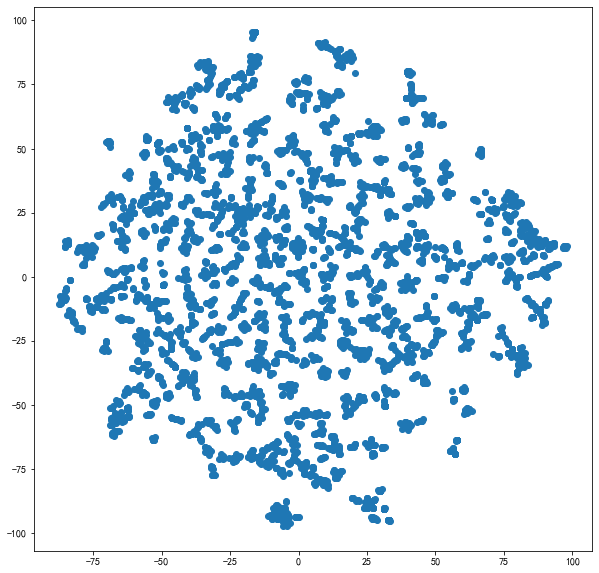

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

In [22]:
# 计算PageRank重要度
pagerank = nx.pagerank(G)
# 从高到低排序
node_importance = sorted(pagerank.items(), key=lambda x:x[1], reverse=True)

# 取最高的前n个节点
n = 30
terms_chosen = []
for each in node_importance[:n]:
    terms_chosen.append(each[0])

In [23]:
# 输入词条，输出词典中的索引号
term2index = model.wv.key_to_index

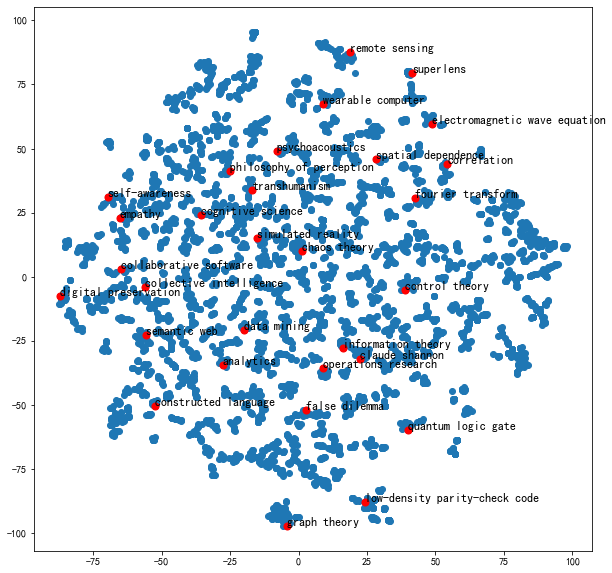

In [34]:
# 可视化全部词条和关键词条的二维Embedding
plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx,0], embed_2d[idx,1],c='r',s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]),c='k',fontsize=12)
plt.show()

### 3.5 TSNE降维可视化

In [28]:
# 将Embedding用TSNE降维到2维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
embed_2d = tsne.fit_transform(X)

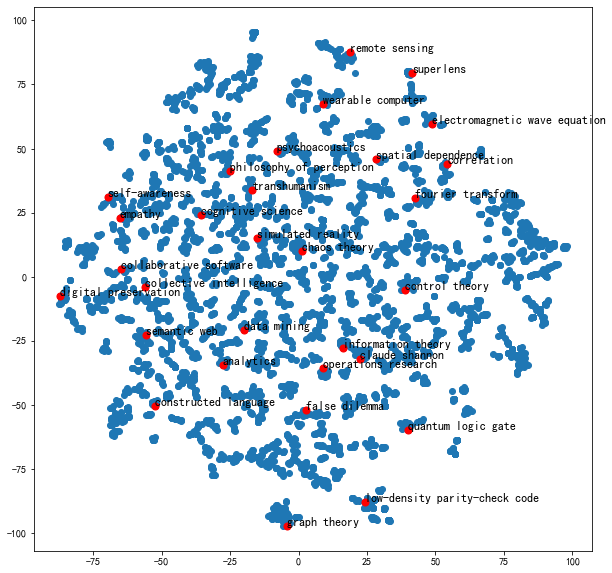

In [33]:
plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx,0], embed_2d[idx,1],c='r',s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]),c='k',fontsize=12)
plt.show()

## 4 本章总结

本章主要讲解了DeepWalk算法，包括：

- DeepWalk简介：图嵌入、Word2Vec词嵌入、PPT内容讲解
- DeepWalk论文精读：DeepWalk能够把节点编码成低维、稠密、连续的向量，包含节点的结构、连接、社群特征，虽然不包含类别信息，但可用于预测类别信息
- DeepWalk代码实战：使用维基百科词条数据构建无向图，生成随机游走节点序列，训练Word2Vec模型，通过计算PageRank得到关键词条，并进行可视化展示